<a href="https://colab.research.google.com/github/Jom123410/280222/blob/master/Counterfeit_cashier_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This a FastAI  program designed to detect counterfeit cashier's checks. This software uses deep learning algorithms to analyze various features of the check and compare them against known patterns of genuine checks. The program is specifically designed to identify fraudulent checks that have been altered or forged in some way, including checks that have been created using sophisticated printing techniques. 

In [1]:
# Install and setup Fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import necessary modules
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# Search for counterfeit cashier's check images
ims = search_images_ddg('counterfeit cashier check')

In [4]:
# Download the first image
dest = 'sample_data/counterfeit_check.jpg'
download_url(ims[0], dest, show_progress=False)

Path('sample_data/counterfeit_check.jpg')

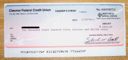

In [5]:
# Open the image and create a thumbnail
im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
# Define categories and create a path to store images
check_types = 'Genuine cashier check', 'Counterfeit cashier check'
path = Path('checks')

In [7]:
# Create folders for each category and download images
if not path.exists():
    path.mkdir()
    for o in check_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} counterfeit cashier check')
        download_images(dest, urls=results)

In [8]:
# Get image file names
fns = get_image_files(path)

In [9]:
# Verify image files and remove any that are corrupt
failed = verify_images(fns)
failed.map(Path.unlink)

(#19) [None,None,None,None,None,None,None,None,None,None...]

In [10]:
# Define a DataBlock for the image classification task
checks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
# Create dataloaders from the DataBlock
dls = checks.dataloaders(path)

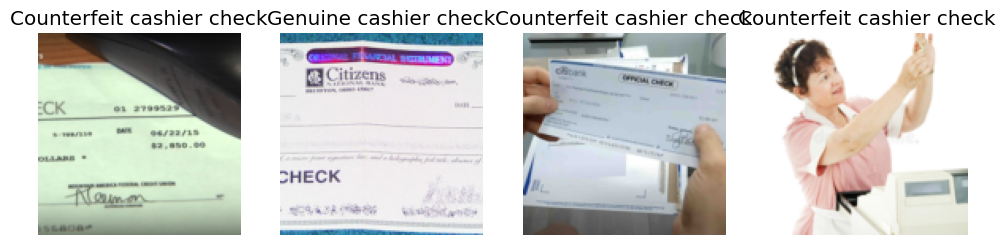

In [12]:
# Show a batch of validation images
dls.valid.show_batch(max_n=4, nrows=1)

In [13]:
# Add more data augmentation to the DataBlock
checks = checks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())

In [14]:
# Create dataloaders again with the updated DataBlock
dls = checks.dataloaders(path)

In [15]:
# Create a learner using the ResNet18 model
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [16]:
# Fine-tune the learner for 4 epochs
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
# Get interpretation object from the learner
interp = ClassificationInterpretation.from_learner(learn)

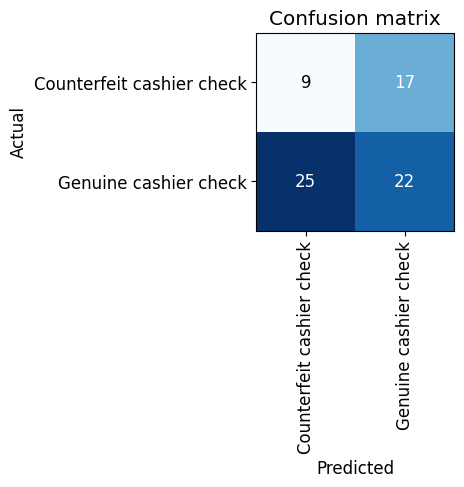

In [18]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

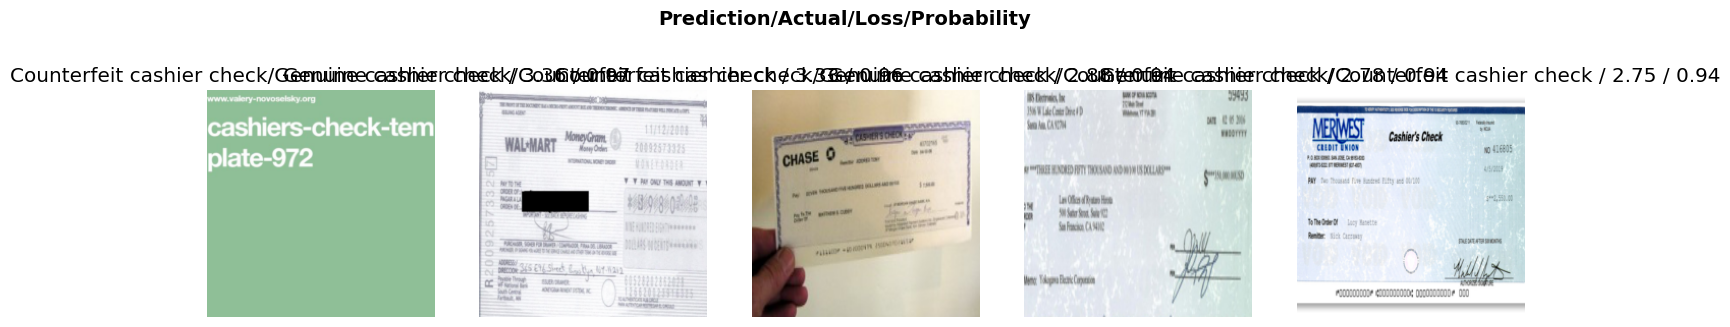

In [19]:
# Plot the top losses
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [20]:
# Create an ImageClassifierCleaner object to interactively remove misclassified images
cleaner = ImageClassifierCleaner(learn)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [24]:
# Show the cleaner
cleaner

In [25]:
# Delete images marked for deletion by the cleaner
for x in cleaner.delete():
    cleaner.fns[x].unlink()

In [26]:
# Move images to their correct category folder, as marked by the cleaner
for y, cat in cleaner.change():
    shutil.move(str(cleaner.fns[y]), path/cat)

In [ ]:
# Clean up memory in Colab
from google.colab import runtime
runtime.unassign()